<a href="https://colab.research.google.com/github/Chandrachapa/C_learning/blob/master/ellipse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

d:  [2 3]
Optimal value: -1.0589292018409964
centroids:  [[ 1.00097941  1.00045749  0.99041877]
 [ 0.00834718  1.00214379 -0.01431355]
 [ 1.49823975  1.49949639  1.00595943]]


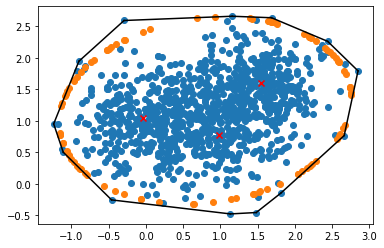

Optimal value: -1.3612971189579093
centroids:  [[ 1.00097941  1.00045749  0.99041877]
 [ 0.00834718  1.00214379 -0.01431355]
 [ 1.49823975  1.49949639  1.00595943]]


<Figure size 432x288 with 0 Axes>

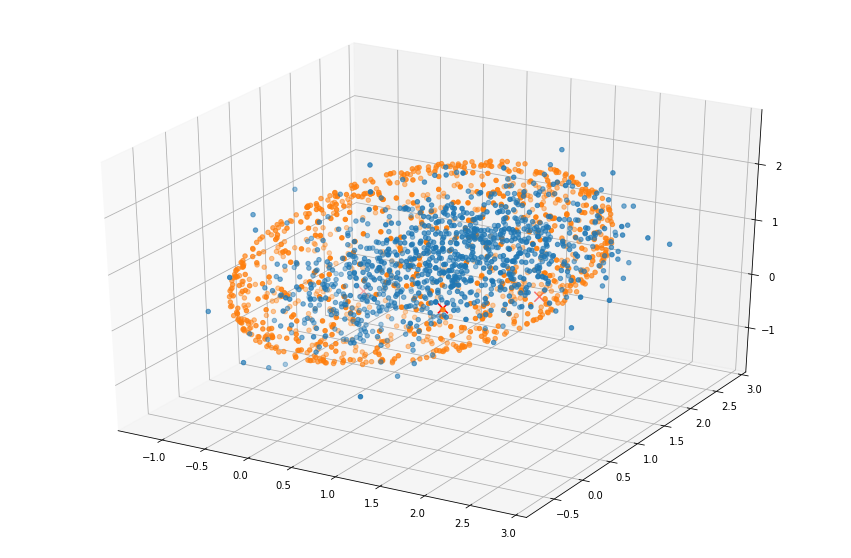

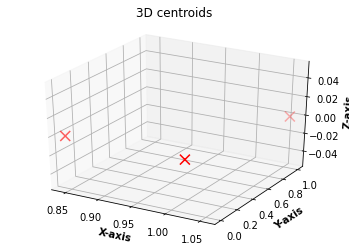

closest points to centroids in n clusters :  [1 2 0]


<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from collections import Counter
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#From: https://stackoverflow.com/a/61786434/752843
def random_point_ellipsoid(a,b,c,x0,y0,z0):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    u = np.random.rand()
    v = np.random.rand()
    theta = u * 2.0 * np.pi
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return rx, ry, rz

def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Npts):
  if dims==2:
    W = sklearn.datasets.make_spd_matrix(2)
    d = np.array([2,3])
    print("d: ",d)
    #form clusters 2d 
    centers = [[0, 1], [1.5, 1.5], [1, 1]]
    stds = [0.13, 0.12, 0.12]
    points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)
    #points = np.array([random_point_ellipse(W,d) for i in range(Npts)])
    #print("points: ",points)
  elif dims==3:
    #form clusters 3d
    centers = [[0, 1, 0], [1.5, 1.5, 1], [1, 1, 1]]
    stds = [0.13, 0.12, 0.12]
    points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)
    #points = np.array([random_point_ellipsoid(3,5,7,2,3,3) for i in range(Npts)])
    #print("3d points: ",points)
  else:
    raise Exception("dims must be 2 or 3!")
  noise = np.random.multivariate_normal(mean=[0]*dims, cov=0.2*np.eye(dims), size=Npts)
  return points+noise

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def Plot(points, hull, B, d):
  fig = plt.figure()
  if points.shape[1]==2:
    K = 3
    kmeans_model = KMeans(n_clusters=K).fit(points)
    centers = np.array(kmeans_model.cluster_centers_)
    ax = fig.add_subplot(111)
    ax.scatter(points[:,0], points[:,1])
    ax.scatter(centers[:,0], centers[:,1], c = 'r', marker ='x') 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids: ",centroids)
    for simplex in hull.simplices:
      plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(100)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1])
  elif points.shape[1]==3:
    K = 3
    kmeans_model = KMeans(n_clusters=K).fit(points)
    centers = np.array(kmeans_model.cluster_centers_)
    fig = plt.figure(figsize = (15, 10)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    ax.scatter(centers[:,0], centers[:,1], c = 'r', marker ='x',s=100) 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids: ",centroids)
    display_points = np.array([random_point_ellipsoid(1,1,1,0,0,0) for i in range(1000)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1], display_points[:,2])
  plt.show()

def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  Plot(points, hull, B.value, d.value)
    
  return B.value, d.value

FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Npts=1000))
FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=3, Npts=1000))

#what are the centers of the k clusters in the whole region
# KMeans algorithm 
K = 3
kmeans_model = KMeans(n_clusters=K).fit(points)
#print(kmeans_model.cluster_centers_)
centers = np.array(kmeans_model.cluster_centers_)
#fig = plt.figure(figsize = (15, 10)) 
ax = plt.axes(projection ="3d") 
# Creating plot 
sctt = ax.scatter3D(centers[:,0], centers[:,1], c = 'r', marker ='x',s=100) 
plt.title("3D centroids\n") 
ax.set_xlabel('X-axis', fontweight ='bold')  
ax.set_ylabel('Y-axis', fontweight ='bold')  
ax.set_zlabel('Z-axis', fontweight ='bold') 
  
# show plot 
plt.show()
plt.savefig('convex_hulls.png', dpi=300, bbox_inches="tight")

#data point closest to the centroid of cluster
km = KMeans(n_clusters=3).fit(points)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, points)
#nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(points)
print("closest points to centroids in n clusters : ",closest)

In [ ]:
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> from sklearn.metrics import pairwise_distances_argmin_min
>>> X = np.random.randn(10, 4)
>>> km = KMeans(n_clusters=2).fit(X)
>>> closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)
>>> closest


array([0, 8])

In [ ]:
from collections import Counter
import math

def knn(data, query, k, distance_fn, choice_fn):
    neighbor_distances_and_indices = []
    
    # 3. For each example in the data
    for index, example in enumerate(data):
        # 3.1 Calculate the distance between the query example and the current
        # example from the data.
        distance = distance_fn(example[:-1], query)
        
        # 3.2 Add the distance and the index of the example to an ordered collection
        neighbor_distances_and_indices.append((distance, index))
    
    # 4. Sort the ordered collection of distances and indices from
    # smallest to largest (in ascending order) by the distances
    sorted_neighbor_distances_and_indices = sorted(neighbor_distances_and_indices)
    
    # 5. Pick the first K entries from the sorted collection
    k_nearest_distances_and_indices = sorted_neighbor_distances_and_indices[:k]
    
    # 6. Get the labels of the selected K entries
    k_nearest_labels = [data[i][-1] for distance, i in k_nearest_distances_and_indices]

    # 7. If regression (choice_fn = mean), return the average of the K labels
    # 8. If classification (choice_fn = mode), return the mode of the K labels
    return k_nearest_distances_and_indices , choice_fn(k_nearest_labels)

def mean(labels):
    return sum(labels) / len(labels)

def mode(labels):
    return Counter(labels).most_common(1)[0][0]

def euclidean_distance(point1, point2):
    sum_squared_distance = 0
    for i in range(len(point1)):
        sum_squared_distance += math.pow(point1[i] - point2[i], 2)
    return math.sqrt(sum_squared_distance)

def main():
    '''
    # Regression Data
    # 
    # Column 0: height (inches)
    # Column 1: weight (pounds)
    '''
    reg_data = [
       [65.75, 112.99],
       [71.52, 136.49],
       [69.40, 153.03],
       [68.22, 142.34],
       [67.79, 144.30],
       [68.70, 123.30],
       [69.80, 141.49],
       [70.01, 136.46],
       [67.90, 112.37],
       [66.49, 127.45],
    ]
    
    # Question:
    # Given the data we have, what's the best-guess at someone's weight if they are 60 inches tall?
    reg_query = [60]
    reg_k_nearest_neighbors, reg_prediction = knn(
        reg_data, reg_query, k=3, distance_fn=euclidean_distance, choice_fn=mean
    )
    
    '''
    # Classification Data
    # 
    # Column 0: age
    # Column 1: likes pineapple
    '''
    clf_data = [
       [22, 1],
       [23, 1],
       [21, 1],
       [18, 1],
       [19, 1],
       [25, 0],
       [27, 0],
       [29, 0],
       [31, 0],
       [45, 0],
    ]
    # Question:
    # Given the data we have, does a 33 year old like pineapples on their pizza?
    clf_query = [33]
    clf_k_nearest_neighbors, clf_prediction = knn(
        clf_data, clf_query, k=3, distance_fn=euclidean_distance, choice_fn=mode
    )
    print(reg_prediction)

if __name__ == '__main__':
    main()

128.24666666666667


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
print(nbrs)

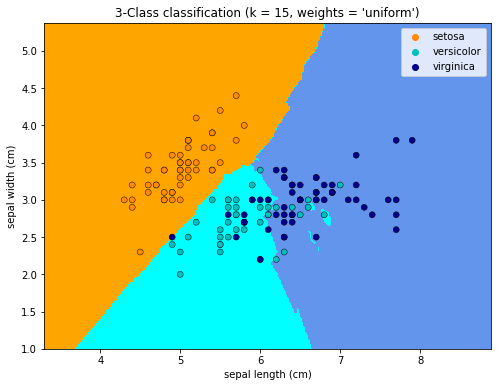

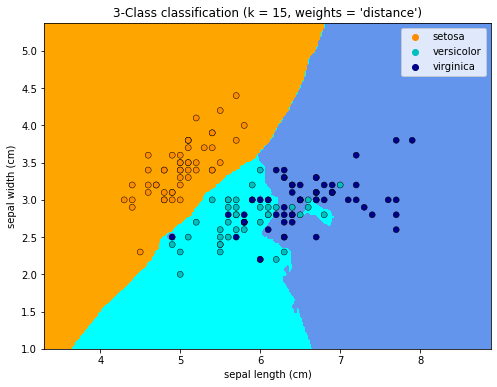

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y],
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

In [ ]:
pip install quadprog


In [ ]:
from sklearn.neighbors import NearestCentroid
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
print(y)
clf = NearestCentroid()
clf.fit(X, y)

print(clf.predict([[-0.8, -1]]))

[1 1 1 2 2 2]
[1]
